In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".25"
import numpy as np
from pathlib import Path
from utils import simulation2d as project
from flowrec import losses
import flowrec.physics_and_derivatives as derivatives
from flowrec.models.cnn import Model
import jax 
import jax.numpy as jnp
from jax import lax
from flowrec._typing import Array, Scalar
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from jax.tree_util import tree_map, Partial
from utils.system import on_which_platform

plt.style.use('utils/ppt.mplstyle')

import logging
# logging.getLogger('fr.utils.decomposition').setLevel(logging.DEBUG)

train_test_split = [600,100,100]
# train_test_split = [600,100,100]
learning_rate = 0.0001
mlp_layers = [] # size of the intermediate layers
cnn_channels = [32,16,3]
cnn_filter = [(3,3)]
dropout_rate = 0.00
regularisation_strength = 0.0000
epochs = 80000
nb_batches = 6
re = 100
data_dir = Path("./local_data/re" + str(re))
dt = 0.0002*625
dx = 12/512
dy = 4/128
sensor_slicing_space = np.s_[::15,::10] # taking points as sensors
weighting = [0.1,0.9] # weighting terms for [physics,sensors]
x_base = 132
(ux,uy,pp) = project.read_data(data_dir,x_base)
# ux = ux[:,:200,:]
# uy = uy[:,:200,:]
# pp = pp[:,:200,:]
x = np.stack([ux,uy,pp],axis=0)
######### delete last rows
x = x[:,:,:250,:]



In [2]:
x.shape

(3, 800, 250, 129)

In [3]:
x_mean = np.mean(x,axis=1)
x_fluc = np.swapaxes(x,0,1) - x_mean
print(np.allclose(x_mean+x_fluc,np.swapaxes(x,0,1)))
print(x_mean.shape, x_fluc.shape)

True
(3, 250, 129) (800, 3, 250, 129)


Average divergence

In [4]:
dum_dx = derivatives.derivative1(x_mean[0,...],dx,0)
dvm_dy = derivatives.derivative1(x_mean[1,...],dy,1)

2.8011194e-05


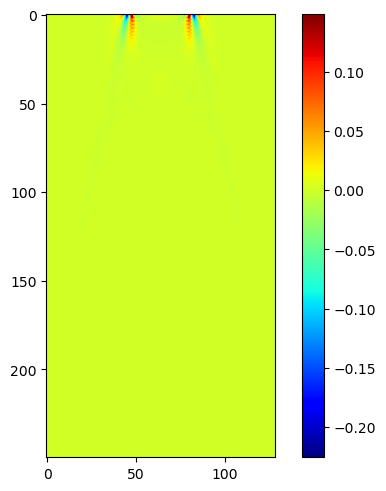

In [5]:
divm = dum_dx + dvm_dy 
print(losses.mse(divm))
plt.figure()
plt.imshow(divm)
plt.colorbar()
plt.show()

RANS

In [6]:
x_fluc.shape

(800, 3, 250, 129)

In [17]:
rs_uu = x_fluc[:,0,:,:]**2
rs_uv = x_fluc[:,0,:,:]*x_fluc[:,1,:,:]
rs_vv = x_fluc[:,1,:,:]**2

In [9]:
dum_dx = derivatives.derivative1(x_mean[0,:,:],dx,axis=0)
um_dum_dx = x_mean[0,...]*dum_dx
dum_dy = derivatives.derivative1(x_mean[0,:,:],dy,axis=1)
vm_dum_dy = x_mean[1,...]*dum_dy

dpm_dx = derivatives.derivative1(x_mean[2,...],dx,axis=0)

d2um_dx2 = derivatives.derivative2(x_mean[0,...],dx,axis=0)
d2um_dy2 = derivatives.derivative2(x_mean[0,...],dy,axis=1)

druu_dx = derivatives.derivative1(np.mean(rs_uu,axis=0),dx,axis=0)
druv_dy = derivatives.derivative1(np.mean(rs_uv,axis=0),dy,axis=1)

In [22]:
rans_x = um_dum_dx + vm_dum_dy + dpm_dx - (d2um_dx2 + d2um_dy2)/re - (druu_dx + druv_dy)
print(losses.mse(rans_x))

0.12883061


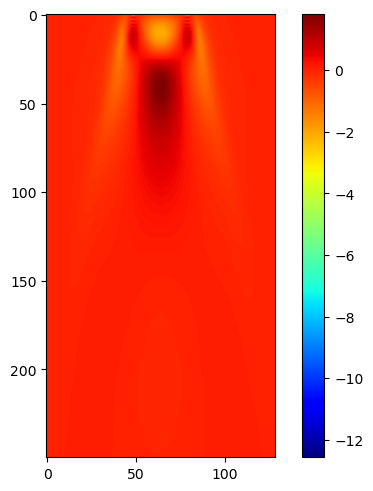

In [14]:
plt.figure()
plt.imshow(rans_x)
plt.colorbar()
plt.show()

In [18]:
dvm_dx = derivatives.derivative1(x_mean[1,:,:],dx,axis=0)
um_dvm_dx = x_mean[0,...]*dvm_dx
dvm_dy = derivatives.derivative1(x_mean[1,:,:],dy,axis=1)
vm_dvm_dy = x_mean[1,...]*dvm_dy

dpm_dy = derivatives.derivative1(x_mean[2,...],dy,axis=1)

d2vm_dx2 = derivatives.derivative2(x_mean[1,...],dx,axis=0)
d2vm_dy2 = derivatives.derivative2(x_mean[1,...],dy,axis=1)

druv_dx = derivatives.derivative1(np.mean(rs_uv,axis=0),dx,axis=0)
drvv_dy = derivatives.derivative1(np.mean(rs_vv,axis=0),dy,axis=1)

0.68641216


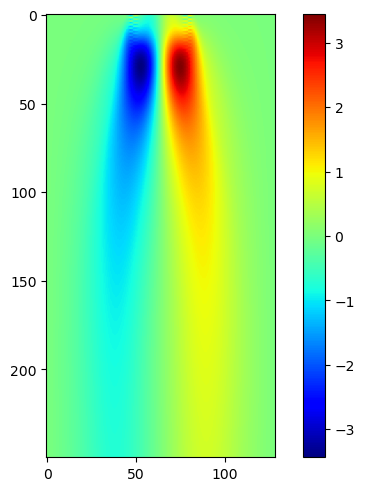

In [23]:
rans_y = um_dvm_dx + vm_dvm_dy + dpm_dy - (d2vm_dx2 + d2vm_dy2)/re - (druv_dx + drvv_dy)
print(losses.mse(rans_y))
plt.figure()
plt.imshow(rans_y)
plt.colorbar()
plt.show()